In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/My\ Drive/Colab\ Notebooks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: './drive/My Drive/Colab Notebooks/'
/content/drive/My Drive/Colab Notebooks


In [ ]:
# folder = 'DeepFakeDetection-Frequency Domain'
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from scipy.interpolate import griddata

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

# Process Image

In [ ]:
import pickle

with open('./train_data_list.pickle', 'rb') as f:
  train = pickle.load(f)
with open('./test_data_list.pickle', 'rb') as f:
  test = pickle.load(f)

In [ ]:
def transformFrame(frame, size=300):
  f_transform = np.fft.fft2(img)
  fshift = np.fft.fftshift(f_transform)
  magnitude_spectrum = 20*np.log(np.abs(fshift))
  psd1D = azimuthalAverage(magnitude_spectrum)
  points = np.linspace(0,size,num=psd1D.size)
  xi = np.linspace(0,size,num=size)
  interpolated = griddata(points,psd1D,xi,method='cubic')
  interpolated /= interpolated[0]
  return interpolated

In [ ]:
train[0][0][:-4] + '_' + str(0) + '.jpg'

'ugdlazckto_0.jpg'

In [ ]:
rootdirs = ['./test_dataset/real/0_real_5fps/', './test_dataset/fake/1_fake_5fps/']
size = 300
real_mean = []
real_std = []
real_datasets = []
real_labels = []
real_count = 0
for pair in train:
  i = 0
  while i < 10:
    if os.path.exists(rootdirs[0] + pair[0][:-4] + '_' + str(i*5) + '.jpg'):
      img = cv2.imread(rootdirs[0] + pair[0][:-4] + '_' + str(i*5) + '.jpg', 0)
      feature = transformFrame(img, size)
      real_datasets.append(feature)
      real_labels.append(1)
    else:
      break
    i+=1
  if i > 0: 
    real_count += 1

for pair in test:
  i = 0
  while i < 10:
    if os.path.exists(rootdirs[0] + pair[0][:-4] + '_' + str(i*5) + '.jpg'):
      img = cv2.imread(rootdirs[0] + pair[0][:-4] + '_' + str(i*5) + '.jpg', 0)
      feature = transformFrame(img, size)
      real_datasets.append(feature)
      real_labels.append(1)
    else:
      break
    i+=1
  if i > 0: 
    real_count += 1

print(real_count)
for x in range(size):
  real_mean.append(np.mean([k[x] for k in real_datasets]))
  real_std.append(np.std([k[x] for k in real_datasets]))


445


In [ ]:
fake_mean = []
fake_std = []
fake_datasets = []
fake_labels = []
fake_count = 0

for pair in train:
  i = 0
  while i < 10:
    if os.path.exists(rootdirs[1] + pair[1][:-4] + '_' + str(i*5) + '.jpg'):
      img = cv2.imread(rootdirs[1] + pair[1][:-4] + '_' + str(i*5) + '.jpg', 0)
      feature = transformFrame(img, size)
      fake_datasets.append(feature)
      fake_labels.append(0)
    else:
      break
    i+=1
  if i > 0: 
    fake_count += 1

for pair in test:
  i = 0
  while i < 10:
    if os.path.exists(rootdirs[1] + pair[1][:-4] + '_' + str(i*5) + '.jpg'):
      img = cv2.imread(rootdirs[1] + pair[1][:-4] + '_' + str(i*5) + '.jpg', 0)
      feature = transformFrame(img, size)
      fake_datasets.append(feature)
      fake_labels.append(0)
    else:
      break
    i+=1
  if i > 0: 
    fake_count += 1
print(fake_count)
for x in range(size):
  fake_mean.append(np.mean([k[x] for k in fake_datasets]))
  fake_std.append(np.std([k[x] for k in fake_datasets]))

442


# Model Loading

In [ ]:
import pickle
SVM = pickle.load(open('DeepFakeDetection-Frequency Domain/models/SVM model.pkl', 'rb'))
# LR = pickle.load(open('DeepFakeDetection-Frequency Domain/models/LR model.pkl', 'rb'))
SVM

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


SVC(C=6.37, break_ties=True, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.86, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
all_labels = np.concatenate((real_labels, fake_labels))
all_data = np.concatenate((real_datasets, fake_datasets))

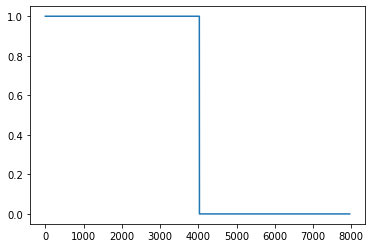

In [ ]:
plt.plot(all_labels)

Text(0, 0.5, 'Power Spectrum')

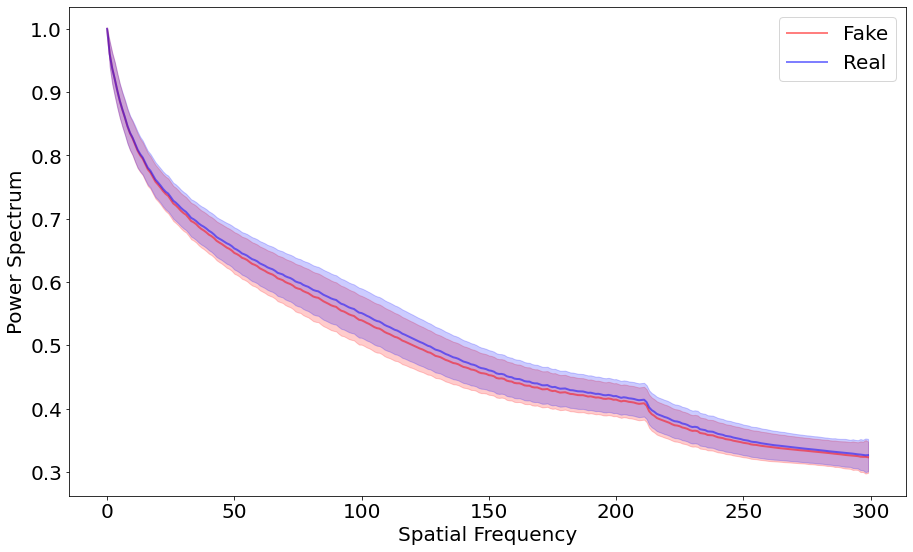

In [ ]:
# Plot
x = np.arange(0, size, 1)
fig, ax = plt.subplots(figsize=(15, 9))
fake_mean_np = np.array(fake_mean)
real_mean_np = np.array(real_mean)
fake_std_np = np.array(fake_std)
real_std_np = np.array(real_std)
ax.plot(x, fake_mean_np, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, fake_mean_np - fake_std_np, fake_mean_np + fake_std_np, color='red', alpha=0.2)
ax.plot(x, real_mean_np, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, real_mean_np - real_std_np, real_mean_np + real_std_np, color='blue', alpha=0.2)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

In [ ]:
svm_score = SVM.score(all_data, all_labels)
lr_score = LR.score(all_data, all_labels)
print("SVM: "+str(svm_score))
print("LR: "+str(lr_score))

SVM: 0.5317919075144508
LR: 0.5335511435033928


In [ ]:
print(SVM)

SVC(C=6.37, break_ties=None, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.86, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86, break_ties=True)
svclassifier_r.fit(all_data, all_labels)
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
logreg.fit(all_data, all_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
svm_score = svclassifier_r.score(all_data, all_labels)
lr_score = logreg.score(all_data, all_labels)
print("SVM: "+str(svm_score))
print("LR: "+str(lr_score))

SVM: 0.6622266901231465
LR: 0.6122141241517969


In [ ]:
train_all = np.concatenate((real_datasets[:len(real_datasets)//4*3], fake_datasets[:len(fake_datasets)//4*3]))
test_all = np.concatenate((real_datasets[len(real_datasets)//4*3:], fake_datasets[len(fake_datasets)//4*3:]))

In [ ]:
print(len(train_all))
print(len(test_all))

5967

In [ ]:
train_label = np.concatenate((real_labels[:len(real_datasets)//4*3], fake_labels[:len(fake_datasets)//4*3]))
test_label = np.concatenate((real_labels[len(real_datasets)//4*3:], fake_labels[len(fake_datasets)//4*3:]))

In [ ]:
len(test_all)

1991

In [ ]:
svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86, break_ties=True)
svclassifier_r.fit(train_all, train_label)
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
logreg.fit(train_all, train_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
svm_score = svclassifier_r.score(test_all, test_label)
lr_score = logreg.score(test_all, test_label)
print("SVM: "+str(svm_score))
print("LR: "+str(lr_score))

SVM: 0.629331993972878
LR: 0.598694123556002
